# Similarity Clustering

The goal of similarity clustering is to build a graph in order to cluster the companies based on their similarity. We ended up with 9034 features, most of them being indicator variable.

There are a few clustering approaches we can take:
1. Direct clustering with unsupervised methods: k-means. An investigation can be done to to tune the number of clusters _k_
2. Latent features models: mixture models; we can first use dimensionality reduction (NMF, PCA), and then compute the distance matrix from the new features. 
3. Exploitation of a distance matrix of size $n \times n$  that holds the euclidean distance between each pair of companies.


Based on these matrices, we can provide the nearest neighbors for a given entry.


We can use multi-dimensional scaling to find an optimized lower dimensionality representation of the data  As this algorithm requires a lot of time to run, we attempted it on a sub-sample of the data. 2D or 3D may be helpful for a nice visualization. 



In [191]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import datetime
import time
import seaborn as sns

# 1 Formating the data

### 1.1 Loading Data

In [4]:
# Loading the data
# Files too big (can be downloaded from the ipython notebook ensemble method)
df = pd.read_csv("../df.csv", index_col='Unnamed: 0')

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
# Need to have numerical features only
df['year_founded'] = df['month_founded'].str[:4]
df['month_founded'] = df['month_founded'].str[-2:]

In [6]:
df[['month_founded', 'year_founded']] = df[['month_founded', 'year_founded']].astype(int)

In [14]:
# cleaning the dataframe
df_clean = df.copy()
df_clean = df_clean.drop(['success', 'at_least_4_funding_rounds' , 'acquired_by', 'investors', 'funding_dates', 'text_nouns', 'text_adjectives', 'short_description', 'funding_amounts', 'founder_ages', 'ipo', 'funding_rounds'], axis=1)
df_clean = df_clean.drop(['acquisitions', 'board_members_and_advisors', 'founders', 'offices', 'headquarters', 'founder_names', 'moonth_founded'], axis=1)

# The columns competitors and categories should be helpful to create similarity, we could use them as additional weights.
competitors = df_clean[['competitors']]
categories = df_clean[['categories']]

df_clean = df_clean.drop(['categories', 'competitors'], axis=1)
# Too many missing values
df_clean = df_clean.drop(['founder_ages_mean'], axis=1)
# Reject NaN value (concerns funding_mean values)
df_clean = df_clean.dropna(how='any')

In [24]:
# Need to standardize the numerical features to make them comparable to the binary one
# We keep the counts feature unchanged
for c in ['funding_mean', 'funding_total']:
    df_clean[c] = (df_clean[c] - df_clean[c].mean())/(df_clean[c].std())


In [121]:
df_clean.dtypes

month_founded                          int64
c_Marketplaces_i                        bool
c_Veterinary_i                          bool
c_Crowdsourcing_i                       bool
c_Data Privacy_i                        bool
c_B2B_i                                 bool
c_Online Video Advertising_i            bool
c_Event Management_i                    bool
c_Corporate IT_i                        bool
c_Health and Insurance_i                bool
c_Crowdfunding_i                        bool
c_Performance Marketing_i               bool
c_Incentives_i                          bool
c_Social Television_i                   bool
c_Communications Infrastructure_i       bool
c_Collaborative Consumption_i           bool
c_Lighting_i                            bool
c_Virtual Currency_i                    bool
c_Designers_i                           bool
c_Tourism_i                             bool
c_Concentrated Solar Power_i            bool
c_Training_i                            bool
c_Indians_

In [126]:
bool_f = (df_clean.dtypes == bool)
binary_features = df_clean.columns[bool_f]
int_features = df_clean.columns[~bool_f]
int_features

Index([u'month_founded', u'num_funding_rounds', u'funding_mean', u'funding_total', u'num_founders', u'num_competitors', u'num_acquisitions', u'num_board_members_and_advisors', u'year_founded'], dtype='object')

We stored the two different features type in list if needed later.

### 1.2 Dimensionality Reduction

We will use a PCA to reduce the dimension of the features space. We will use it first on the whole dataset, and then on a reduced version considering only the indicator features related to categories and city.


In [27]:
from  sklearn.decomposition import PCA

# We keep 95% of the variance
pca = PCA(n_components=0.95)
%time X_pca = pca.fit_transform(df_clean)

print('PCA decreased the dimension from {} to {}'.format(df_clean.shape[1], pca.n_components_))

CPU times: user 9min 44s, sys: 13.9 s, total: 9min 58s
Wall time: 5min 29s
PCA reduced the dimension from 9015 to 10


In [469]:
# Reducing the columns to only categories and city
cat_col = [c for c in df_clean.columns if c[:2] == "c_"]
city_col = [c for c in df_clean.columns if c[:5] == "city_"]

reduced_cols = cat_col + city_col
df_clean_reduced = df_clean[reduced_cols]

# We keep 95% of the variance
pca_reduced = PCA(n_components=0.95)
%time X_pca_reduced = pca_reduced.fit_transform(df_clean_reduced)

print('PCA on reduced dataframe reduced the dimension from {} to {}'.format(df_clean_reduced.shape[1], pca.n_components_))

CPU times: user 36.5 s, sys: 1.02 s, total: 37.6 s
Wall time: 16.4 s
PCA on reduced dataframe reduced the dimension from 2459 to 10


# 2 Distance Matrix

We compute the distance matrix from the euclidean norm:

In [29]:
from sklearn.metrics.pairwise import pairwise_distances

In [30]:
distance_X_pca = pairwise_distances(X_pca)

In [466]:
distance_X_pca_reduced = pairwise_distances(X_pca_reduced)

In [490]:
distance_X = pairwise_distances(df_clean)

In [488]:
distance_X_reduced = pairwise_distances(df_clean_reduced)

### 2.1 Closest Neighbors

For a given entry, we can now retreive its n closest neighbors:

In [31]:
# Retrieving the mapping permalink2index
permalink2index = {k:i for i, k in enumerate(df_clean.index)}
index2permalink = {i:k for i, k in enumerate(df_clean.index)}

In [443]:
def get_neighbors(permalink, distance_matrix, permalink2index, index2permalink, n=5):
    permalink_index = permalink2index[permalink]
    neighbors_indexes = np.argsort(distance_matrix[permalink_index, :])[1:n+1]
    neighbors_distances = np.sort(distance_matrix[permalink_index, :])[1:n+1]
    return [(index2permalink[i], val) for i, val in zip(neighbors_indexes, neighbors_distances)]
    

We now check the quality of our distance matrix. We built it upon the embedding provided by the PCA based on highly sparse features, so we should not be so confident in its accuracy.

We first check some entries manually and look for their shared attributes with their closest neighbors. We try this approach with 'baidu', 'etsy' and 'paypal', which are known companies.

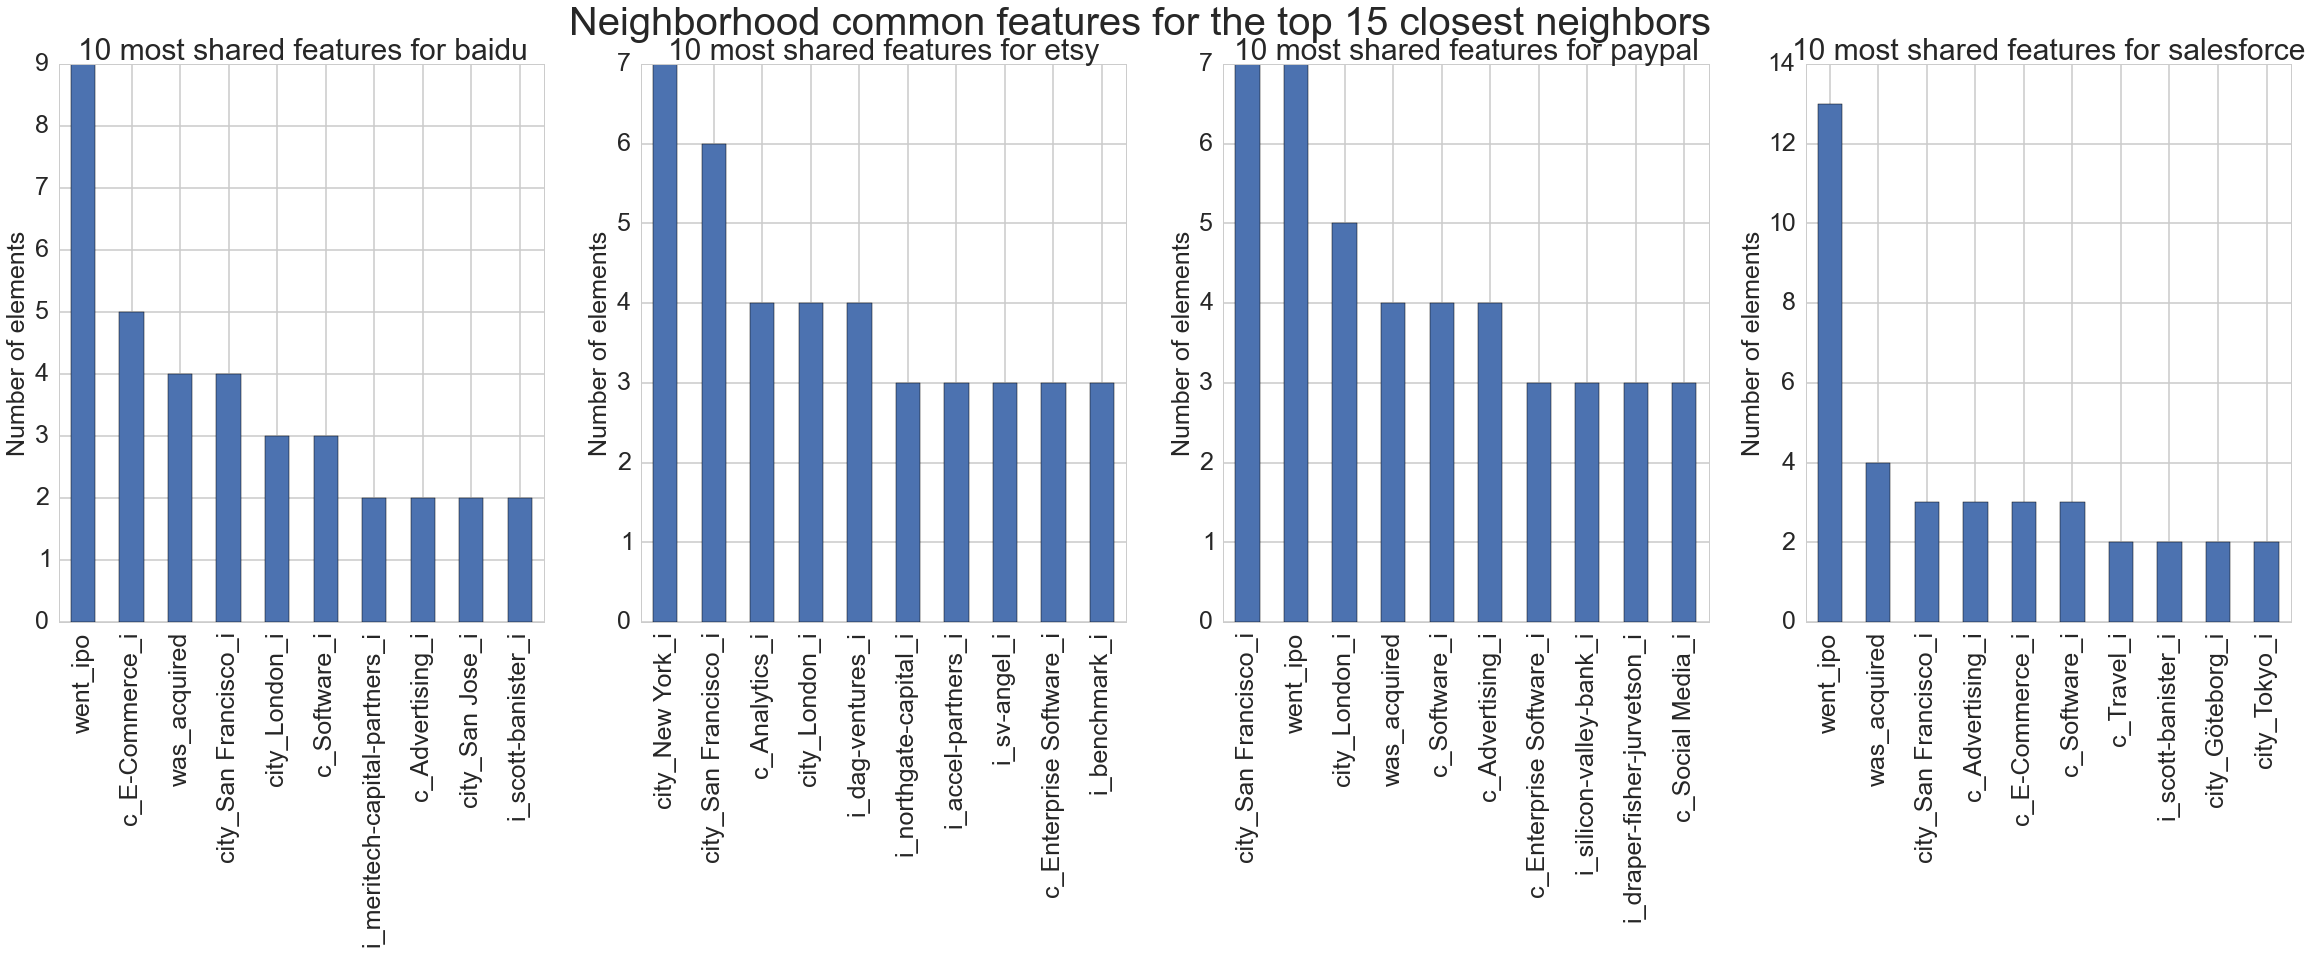

In [486]:
# Test on the whole dataset with distance matrix based on pca over the whole dataset
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

top_shared_features = 10
neighborhhod_size = 15
for ax, company_name in zip(axes.ravel(), ['baidu', 'etsy', 'paypal', 'salesforce']):
    # Building the neighborhood
    list_neighbors = get_neighbors(company_name, distance_X_pca, permalink2index, index2permalink, n=neighborhhod_size)
    shared_bin = df_clean.loc[[c[0] for c in list_neighbors], binary_features].sum()
    shared_bin.sort(ascending=False)

    # Plotting the top shared features
    shared_bin.iloc[:top_shared_features].plot(kind='bar', ax=ax, fontsize=25)

    ax.set_ylabel("Number of elements",fontsize=25)
    ax.set_title('{} most shared features for {}'.format(top_shared_features,company_name), fontsize=30)
    

plt.suptitle ('Neighborhood common features for the top {} closest neighbors'.format(neighborhhod_size), fontsize=40)
plt.show()   

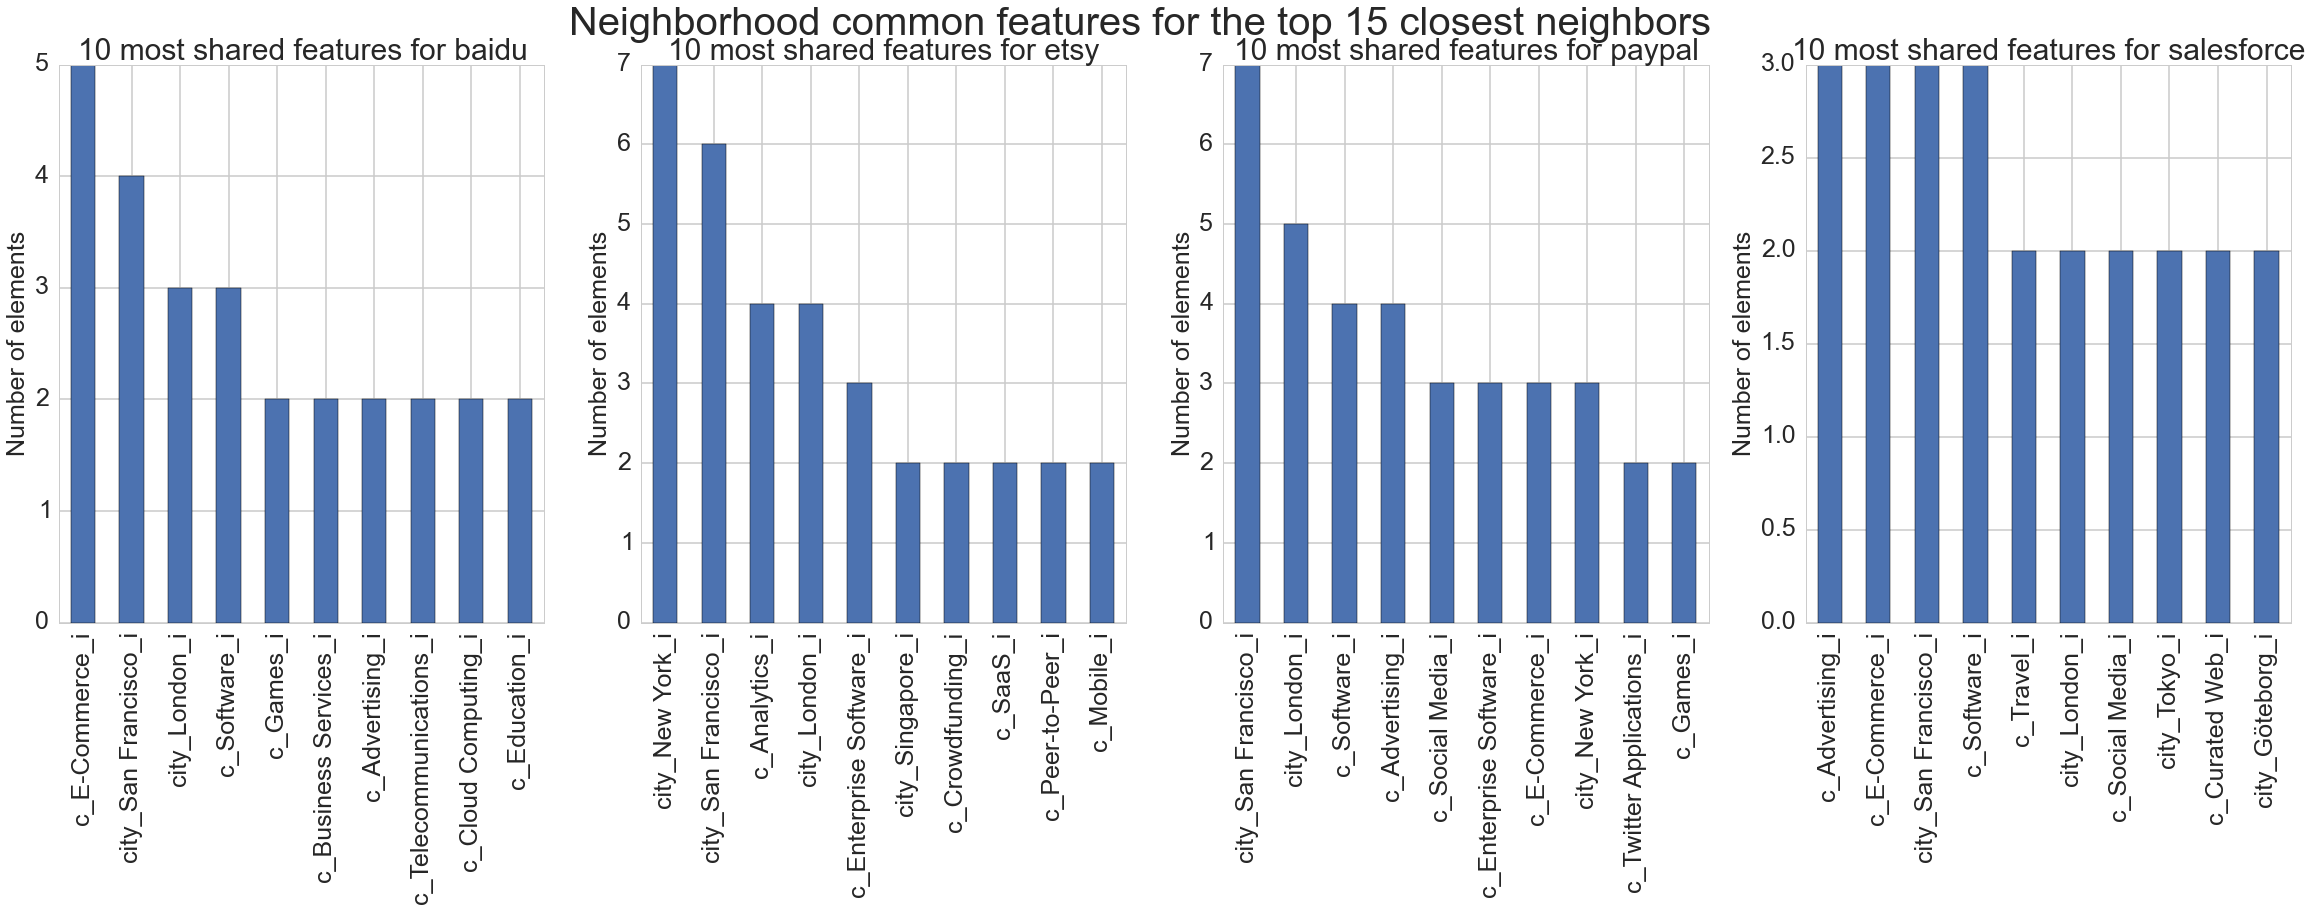

In [493]:
# Test on the reduced dataset with distance matrix based on pca over the whole dataset
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

top_shared_features = 10
neighborhhod_size = 15
for ax, company_name in zip(axes.ravel(), ['baidu', 'etsy', 'paypal', 'salesforce']):
    # Building the neighborhood
    list_neighbors = get_neighbors(company_name, distance_X_pca, permalink2index, index2permalink, n=neighborhhod_size)
    shared_bin = df_clean_reduced.loc[[c[0] for c in list_neighbors], binary_features].sum()
    shared_bin.sort(ascending=False)

    # Plotting the top shared features
    shared_bin.iloc[:top_shared_features].plot(kind='bar', ax=ax, fontsize=25)

    ax.set_ylabel("Number of elements",fontsize=25)
    ax.set_title('{} most shared features for {}'.format(top_shared_features,company_name), fontsize=30)
    

plt.suptitle ('Neighborhood common features for the top {} closest neighbors'.format(neighborhhod_size), fontsize=40)
plt.show() 

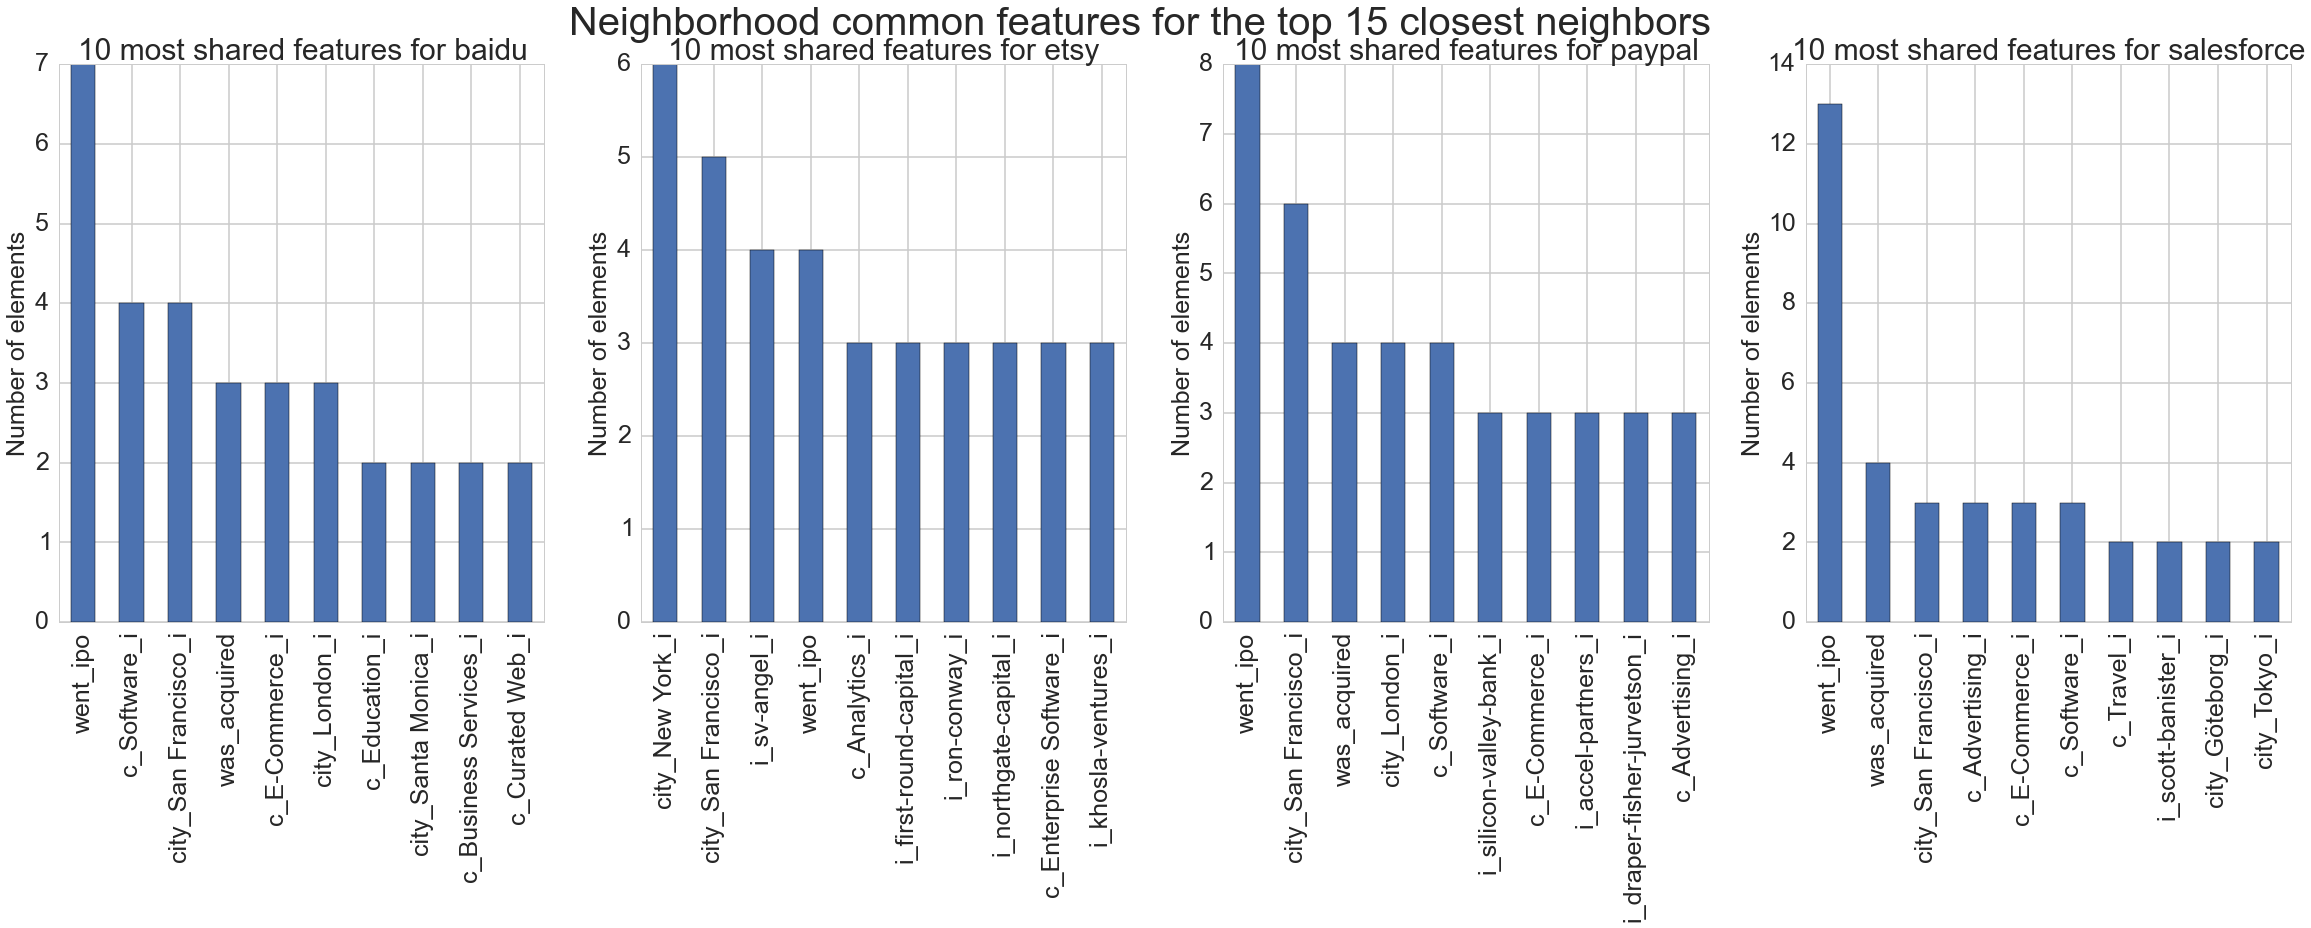

In [492]:
# Test on the reduced dataset with distance matrix based on the raw whole dataset
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

top_shared_features = 10
neighborhhod_size = 15
for ax, company_name in zip(axes.ravel(), ['baidu', 'etsy', 'paypal', 'salesforce']):
    # Building the neighborhood
    list_neighbors = get_neighbors(company_name, distance_X, permalink2index, index2permalink, n=neighborhhod_size)
    shared_bin = df_clean.loc[[c[0] for c in list_neighbors], binary_features].sum()
    shared_bin.sort(ascending=False)

    # Plotting the top shared features
    shared_bin.iloc[:top_shared_features].plot(kind='bar', ax=ax, fontsize=25)

    ax.set_ylabel("Number of elements",fontsize=25)
    ax.set_title('{} most shared features for {}'.format(top_shared_features,company_name), fontsize=30)
    

plt.suptitle ('Neighborhood common features for the top {} closest neighbors'.format(neighborhhod_size), fontsize=40)
plt.show() 

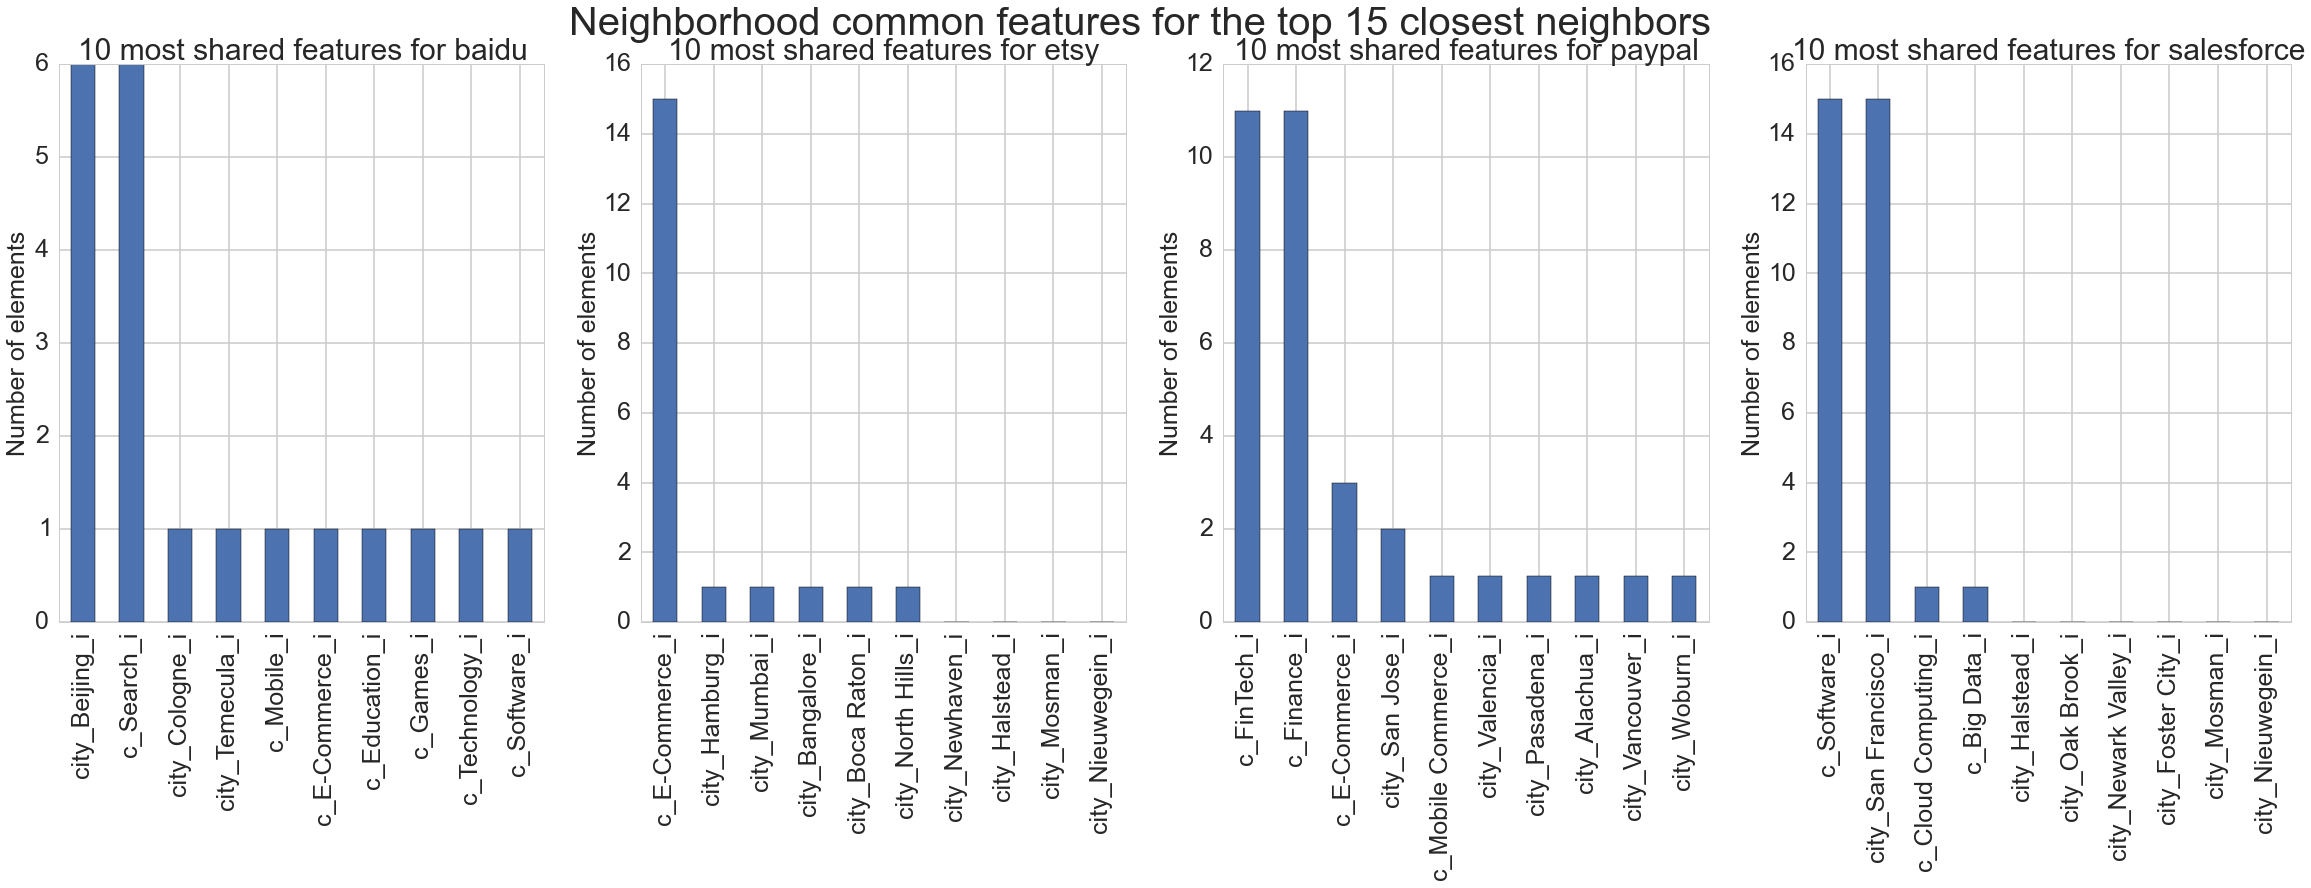

In [489]:
# Test on the reduced dataset with distance matrix based on the raw reduced dataset
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

top_shared_features = 10
neighborhhod_size = 15
for ax, company_name in zip(axes.ravel(), ['baidu', 'etsy', 'paypal', 'salesforce']):
    # Building the neighborhood
    list_neighbors = get_neighbors(company_name, distance_X_reduced, permalink2index, index2permalink, n=neighborhhod_size)
    shared_bin = df_clean_reduced.loc[[c[0] for c in list_neighbors], binary_features].sum()
    shared_bin.sort(ascending=False)

    # Plotting the top shared features
    shared_bin.iloc[:top_shared_features].plot(kind='bar', ax=ax, fontsize=25)

    ax.set_ylabel("Number of elements",fontsize=25)
    ax.set_title('{} most shared features for {}'.format(top_shared_features,company_name), fontsize=30)
    

plt.suptitle ('Neighborhood common features for the top {} closest neighbors'.format(neighborhhod_size), fontsize=40)
plt.show() 

Based on our exploration on known companies in our datasets, it seems that the distance matrix built upon the PCA embedding is not really relevant. The discriminative patterns of the companies are not captured, most likely becaues the PCA reduced the dimension of the data, keeping information of the most represented fields, which are the ones with a lot of non-zeros values (went_ipo, San_francisco, Software...). But the specific variables, like Fintech or Beijing, are removed with the PCA because it does not carry enough information on the overall dataset.

As a result, we should consider the distance matrix built on the whole reduced dataset, which seems to be more relevant in terms of similarity clustering.

### 2.2 Multi-dimensional scaling

Since this algorithm takes a lot of time to run, we executed it on a sub-sample of the data to see how it clusters them.

In [41]:
from sklearn.manifold import MDS
%matplotlib inline

In [494]:
%%time
mds = MDS()
mds_X = mds.fit_transform(distance_X_reduced[:800, :800])

CPU times: user 21 s, sys: 6.55 s, total: 27.5 s
Wall time: 25 s


2D representation

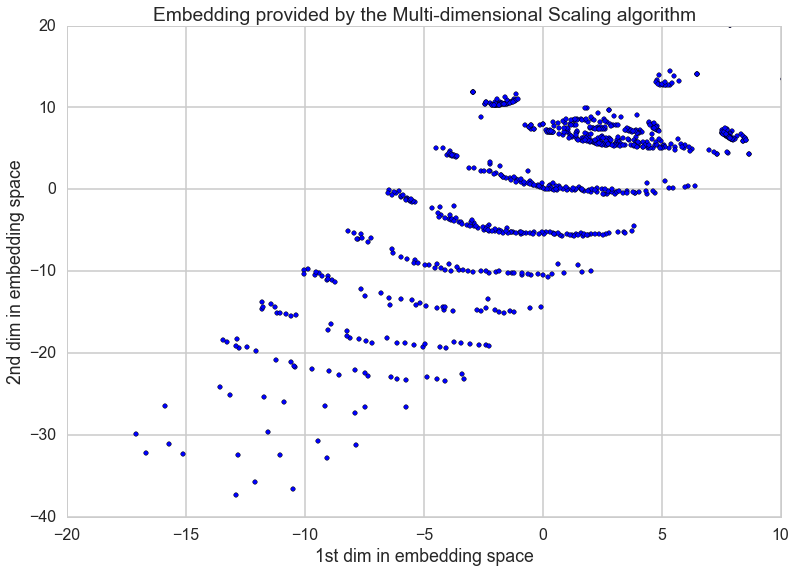

In [496]:
plt.scatter(mds_X[:, 0], mds_X[:, 1])
plt.xlabel('1st dim in embedding space')
plt.ylabel('2nd dim in embedding space')
plt.xlim([-20, 10])
plt.ylim([-40, 20])

plt.title('Embedding provided by the Multi-dimensional Scaling algorithm')
plt.show()

The 2D representation obtained from the MDS algorithm seems to gather the data into clusters represented as roughly horizontal lines.

We could try to further explore the members of this cluster to evaluate their accuracy. This algorithm usually works for projectable data, so if the data are not at all projectable, then the 2D representation is irrelevant.

So far, we built an interesting distance matrix and tried it to project the data but the results are hard to evaluate. We try now 2 classic unsupervised clustering methods to divide our data based on their relationships.

# 3 Unsupervised Learning

 ### 3.1 k-Means

We run a k-Means algorithm. One main issue with this unsupervised clustering method is that we need to set the number of clusters.

There exist some methods to tune this parameter. The most popular empirical version is to use the elbow criterion. The global objective is to find the number of clusters for which the inner-cluster variance stops decreasing drastically. In other words, the marginal gain added by additional clusters becomes really low. The difficulty remains in finding the right 'elbow' on the curve.

In [1]:
from sklearn.cluster import KMeans

In [202]:
%%time
k_range = range(30, 150, 5)
km_dict = {}
X_km_dict = {}
inertias = []
for k in k_range:
    km_pca = KMeans(n_clusters=k)
    X_km_dict[k] = km_pca.fit_predict(X_pca)
    inertias.append(km_pca.inertia_)
    km_dict[k] = km_pca

CPU times: user 1min 6s, sys: 6.56 s, total: 1min 13s
Wall time: 1min 4s


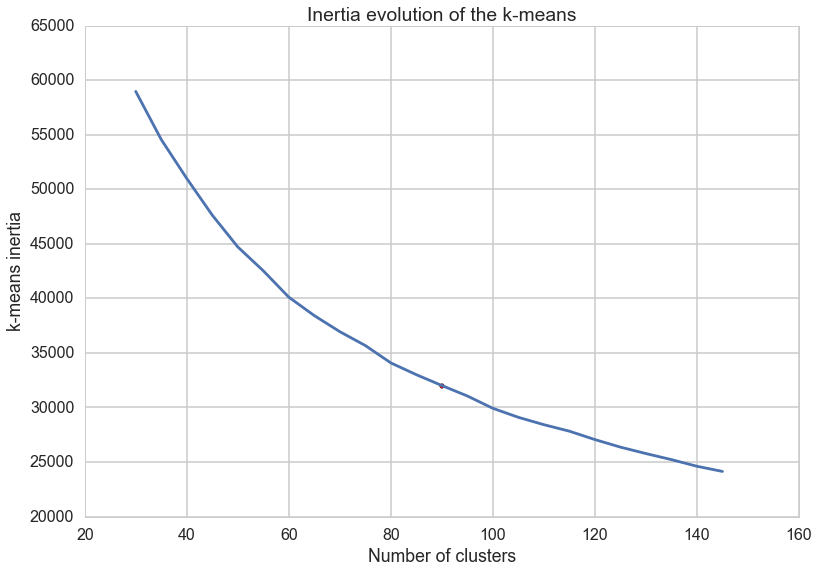

In [203]:
plt.plot(k_range, inertias)
plt.scatter(k_range[12], inertias[12], c='r')

plt.xlabel('Number of clusters')
plt.ylabel('k-means inertia')

plt.title('Inertia evolution of the k-means')

We select the red dot corresponding to **90** clusters as it seems to be the breakpoint of the slope in the curve.

In [207]:
k_best_km = 90
X_km_top = X_km_dict[k_best_km]
import collections
clusters_counter_km = collections.Counter(X_pca_top)

### 3.2 Gaussian Mixture Models

A Gaussian mixture model is a probabilistic assuming the dataset are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

We will compare it here to the k-Means to try to find the most suited to our data

In [160]:
from sklearn.mixture import GMM

In [163]:
%%time
gmm_pca = GMM(n_components=80)
gmm_pca.fit(X_pca)

CPU times: user 4.5 s, sys: 936 ms, total: 5.44 s
Wall time: 4.95 s


In [168]:
X_gmm = gmm_pca.predict(X_pca)
print 'aic ', gmm_pca.aic(X_pca)
print 'bic ', gmm_pca.bic(X_pca)

aic  56541.9312973
bic  67957.0436


In [199]:
%%time
k_range = np.arange(30, 180, 5)
X_gmm_dict = {}
aic = []
bic = []
gmm_dict = {}
X_gmm_dict = {}
for k in k_range:
    gmm_pca = GMM(n_components=k)
    gmm_pca.fit(X_pca)
    aic.append(gmm_pca.aic(X_pca))
    bic.append(gmm_pca.bic(X_pca))
    X_gmm_dict[k] = gmm_pca.predict(X_pca)
    gmm_dict[k] = gmm_pca

CPU times: user 2min 52s, sys: 35.4 s, total: 3min 28s
Wall time: 3min 3s


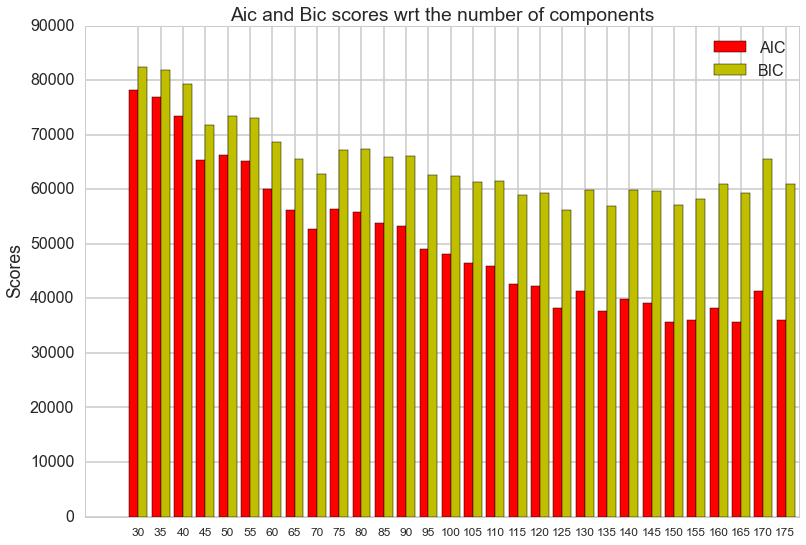

In [200]:
width = 2  

fig, ax = plt.subplots()
rects_aic = ax.bar(k_range, aic, width, color='r')
rects_bic = ax.bar(k_range + width, bic, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Aic and Bic scores wrt the number of components')
ax.set_xticks(k_range + width)
ax.set_xticklabels(k_range, fontsize=12)


ax.legend((rects_aic[0], rects_bic[0]), ('AIC', 'BIC'), loc=1)



plt.show()

To tune the number of clusters with the GMM, we can attempt two different criteria. First, the information-theoretic criteria (BIC) assumes in a Bayesian approach that there exists a true Gaussian mixture underneath the data. Second, the AIC heuristically uses the Kullback-Leibler distance to come up with a model which fits the true with a low number of parameters.

Just like k-means, the selection is done on the point where the score's slope behavior changes. This occurs around the value of 4000 for the AIC score, corresponding to a cluster number of 115. The BIC score stops earlier, around 60,000 for 95 clusters.

Given the high sparseness of the data and our empirical approach, it makes more sense to consider the AIC score. Let's retain the top model with **115** clusters.

In [206]:
k_best_gmm = 115
X_gmm_top = X_km_dict[k_best_gmm]
import collections
clusters_counter_gmm = collections.Counter(X_gmm_top)

### 3.3 Results

We can plot the clusters repartition:

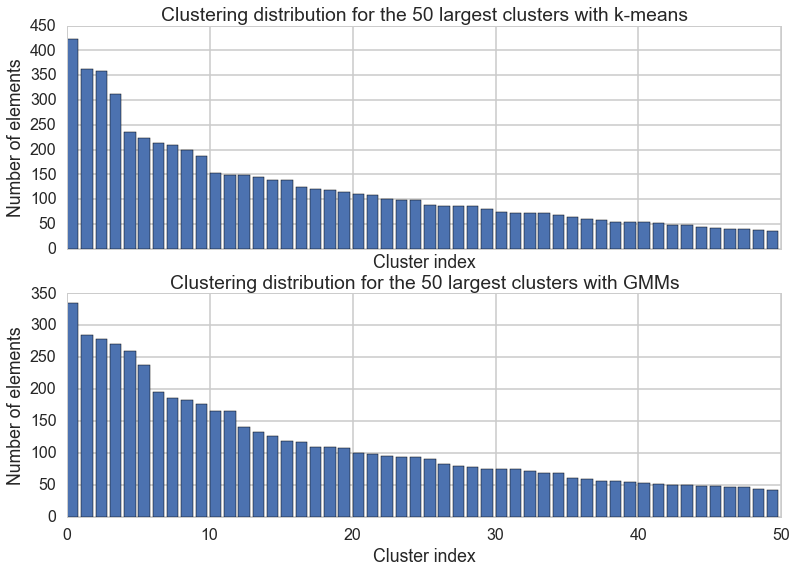

In [211]:
top = 50
top_counts_km = clusters_counter_km.most_common()
top_counts_gmm = clusters_counter_gmm.most_common()

f, axarr = plt.subplots(2, sharex=True)
axarr[0].bar(range(top), [ c[1] for c in top_counts_km[:top]])
axarr[0].set_xlabel('Cluster index')
axarr[0].set_ylabel('Number of elements')
axarr[0].set_title('Clustering distribution for the {} largest clusters with k-means'.format(top))

axarr[1].bar(range(top), [ c[1] for c in top_counts_gmm[:top]])
axarr[1].set_xlabel('Cluster index')
axarr[1].set_ylabel('Number of elements')
axarr[1].set_title('Clustering distribution for the {} largest clusters with GMMs'.format(top))

The distributions is smoother on the GM clustering as expected because we considered more clusters.

Here we try to study more in details a specific cluster, we choose one of size around 50 to 100 to be able to look into the different start ups. We will try to find the shared caracterisctics of these companies

In [148]:
# Cluster example
num_cluster = top_counts[-1][0]
size_cluster = top_counts[-1][1]
cluster_members = [index2permalink[c] for c in np.arange(len(X_pca_top))[X_pca_top == num_cluster]]
print cluster_members

['stillsecure', 'litepoint', 'furiex-pharmaceuticals', 'gen3-partners', 'vendavo', 'bayhill-therapeutics', 'hatchtech', 'technisys-net', 'actinium-pharmaceuticals', 'microfabrica', 'network-merchants', 'posit-science', 'ev3-inc', 'ip-access', 'byallaccounts', 'soa-software', 'median-technologies', 'movaris', 'akademos', 'cenzic', 'e-merges-com', 'mobileaware', 'alterpoint', 'entropic', 'fabric7-systems', 'targegen', 'crisp-wireless', 'cornerstone-pharmaceuticals', 'verge-solutions', 'barosense', 'bdmetrics', 'neteffect', 'evolution-robotics', 'spiration', 'invidi-technologies', 'boingo-wireless', 'axeda', 'zeachem', 'halfpenny-technologies', 'teliris', 'neoguide-systems', 'lancope', 'affinnova', 'broadlogic', 'infopia', 'dexcom', 'fattail', 'ingo-money', 'netspend', 'bocada', 'credant-technologies', 'odyssey-thera', 'aircuity', 'tarari', 'luxim', 'emmaus-medical', 'twisted-pair-solutions', 'digital-fuel', 'liqvid', 'applied-identity', 'azul-systems', 'oryzon-genomics', 'discoverx', 'cl

In [100]:
get_neighbors('furiex-pharmaceuticals', distance_X_pca, permalink2index, index2permalink, n=5)

['broadlogic',
 'athletes-performance',
 'seven-seas-water',
 'orqis-medical',
 'movaris']

Looking manually at the name of each cluster member does not really help since we don't really know them. But it seems that most of them are healthy.

The sum of the binary features show the number of this specific features in the cluster. This may help to define the nature of this cluster.

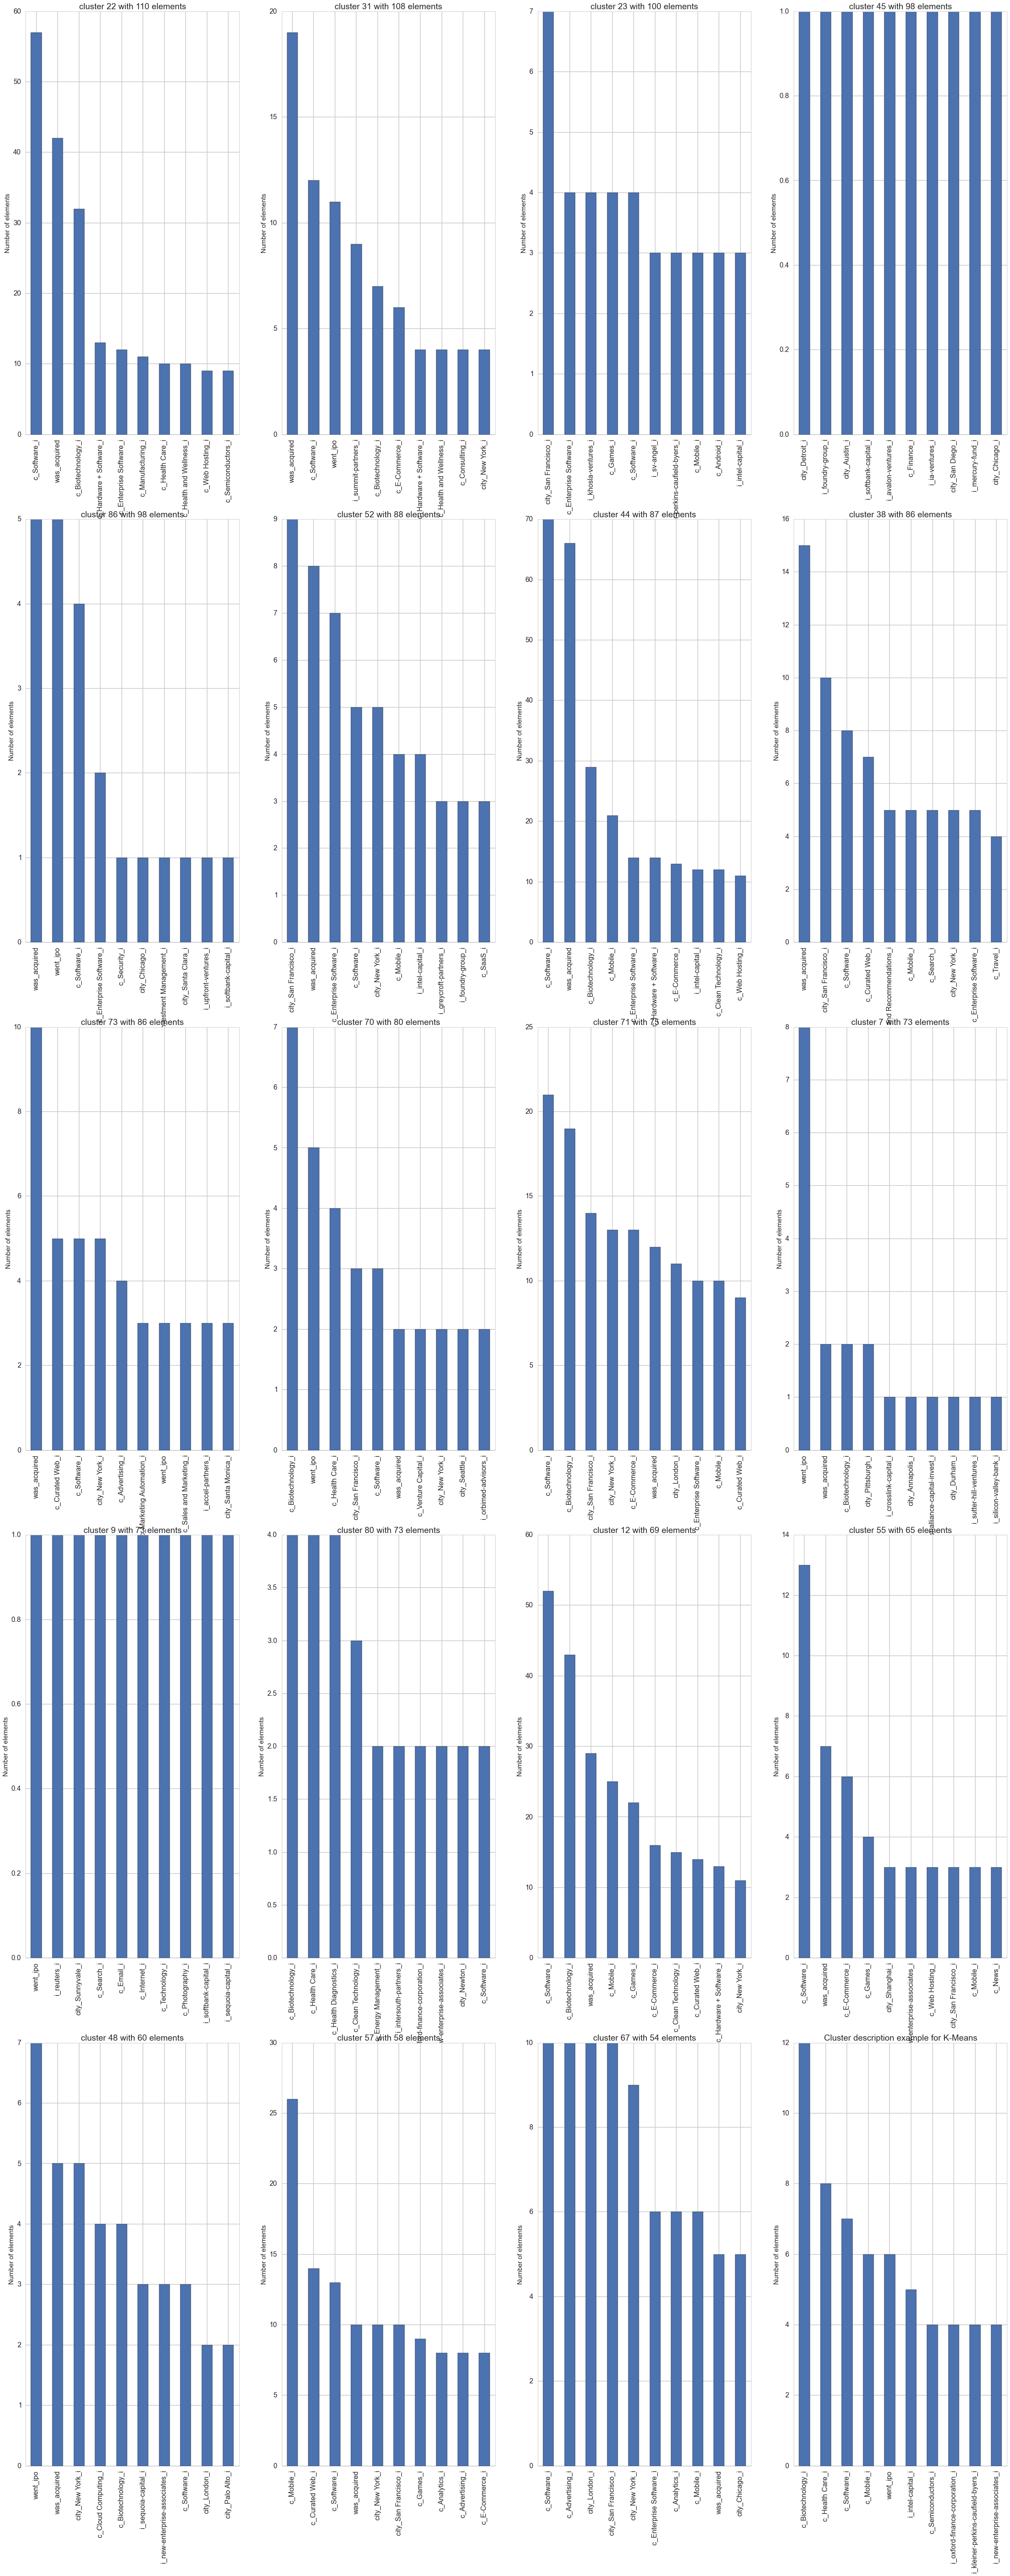

In [232]:
# ###### Cluster description example for K-Means

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(40, 100))

for ax, i in zip(axes.ravel(), range(20, 40)):
    # Cluster selection
    index_cluster = i
    num_cluster = top_counts_km[index_cluster][0]
    size_cluster = top_counts_km[index_cluster][1]
    cluster_members = [index2permalink[c] for c in np.arange(len(X_km_top))[X_km_top == num_cluster]]
    df_cluster = df_clean.loc[cluster_members, :]
    # Only the sum of binary features makes sense
    cum_cluster = df_cluster.sum().loc[binary_features]
    cum_cluster.sort(ascending=False)

    # Plotting the largest binary features
    cum_cluster.iloc[:10].plot(kind='bar', ax=ax)

    ax.set_ylabel("Number of elements",fontsize=15)
    ax.set_title('cluster {} with {} elements'.format(num_cluster, size_cluster))

plt.title('Cluster description example for K-Means')
plt.show()    
    

We took not of some interesting clusters for the k-means:
* around Mobile, Media, Software: cluster 38.
* Biotechnology, Hardware: 22
* Web, mobile, e-commerce, online advertising: 77


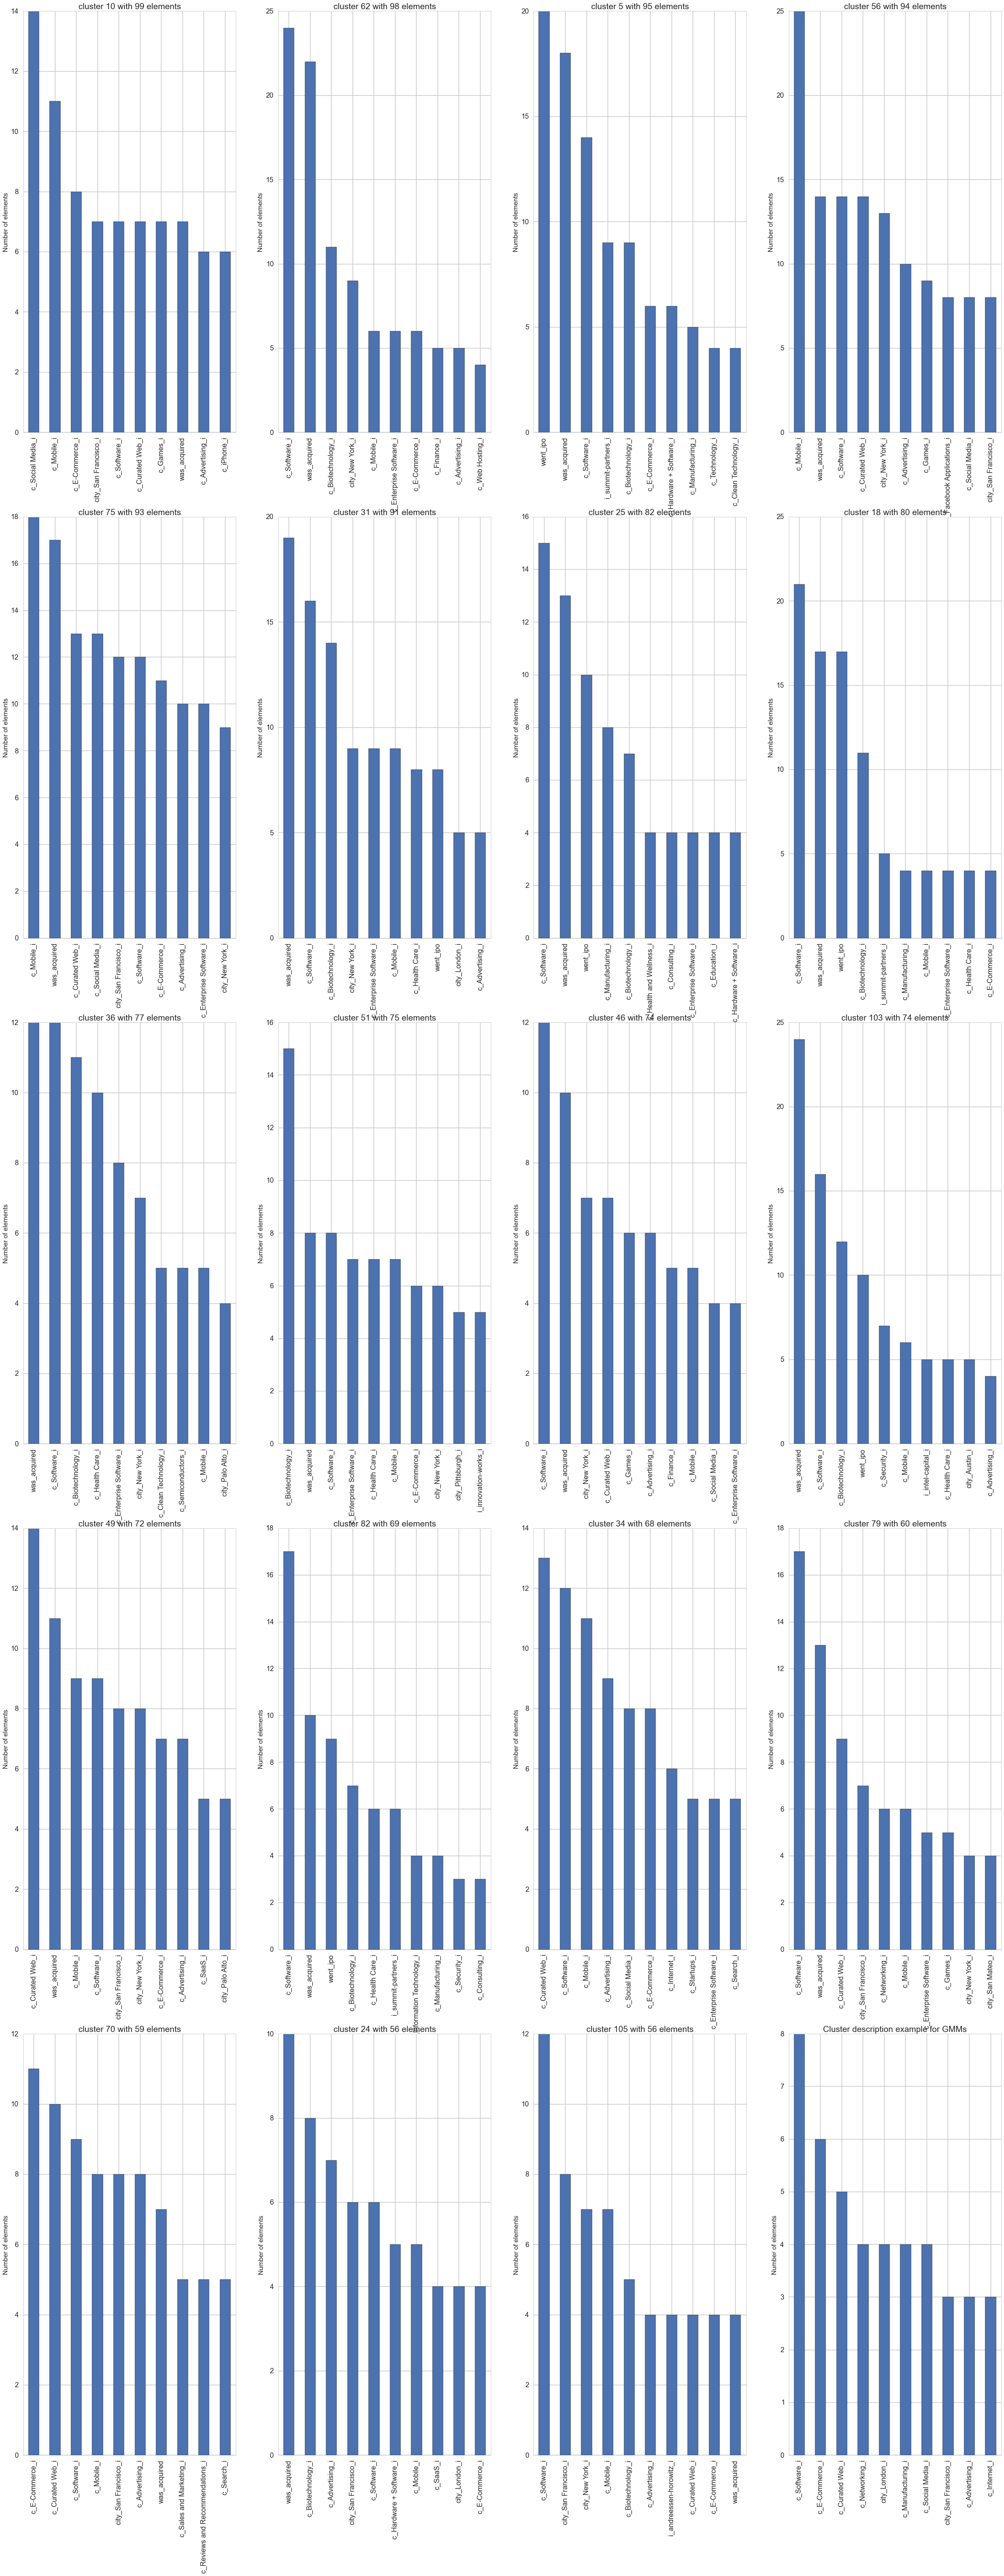

In [233]:
# ###### Cluster description example for GMM

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(40, 100))

for ax, i in zip(axes.ravel(), range(20, 40)):
    # Cluster selection
    index_cluster = i
    num_cluster = top_counts_gmm[index_cluster][0]
    size_cluster = top_counts_gmm[index_cluster][1]
    cluster_members = [index2permalink[c] for c in np.arange(len(X_gmm_top))[X_gmm_top == num_cluster]]
    df_cluster = df_clean.loc[cluster_members, :]
    # Only the sum of binary features makes sense
    cum_cluster = df_cluster.sum().loc[binary_features]
    cum_cluster.sort(ascending=False)

    # Plotting the largest binary features
    cum_cluster.iloc[:10].plot(kind='bar', ax=ax)

    ax.set_ylabel("Number of elements",fontsize=15)
    ax.set_title('cluster {} with {} elements'.format(num_cluster, size_cluster))

plt.title('Cluster description example for GMMs')

plt.show()   

The first results are hard to evaluate. One issue is that the features have the same weights. For instance the country, the categories or the funding information are treated evenly. Maybe we should emphasize the categories. 

We could try to modify this weight or use the list competitors and categories to adjust the clusters.

### 4 Tuned Similarity Mapping

To improve upon the similarity mapping, we could first use the competitors list and convert them into an adjacency matrix to have a graph representation.

Also, as the results from the features are not really impressive, we could improve them with the competitors relationships, finding a way to combine them with the clustering built.

### 4.1 Competitors graph

We will use the library _NetworkX_ to build the competitors graph. The one to many relationship of the attribute competitors provides the list of edges. The code below provides an unweighted graph where we only consider edges.

In [241]:
import networkx as nx

In [243]:
# Creating the graph 
G_competitors = nx.Graph()
G_competitors.add_nodes_from(competitors.index.values)

In [316]:
def parse_competitors(x):
    x = str(x)
    mylist = []
    for t in x.split('{'):
        for u in t.split('}'):
            mylist += u.split(': ')
    myset = set([ t[2:-1] for t in mylist if t[0]=='u'])
    if myset:
        myset.remove('permalink')
    return myset

In [331]:
competitors['competitors_set'] = competitors.competitors.map(parse_competitors)
competitors['neighborhood_len'] = competitors.competitors_set.map(len)

In [337]:
competitors.loc['fantasy-shopper', :]

competitors         [{u'permalink': u'boutiques-com'}, {u'permalin...
competitors_set     set([polyvore, lyst, stardoll, boutiques-com, ...
neighborhood                                                        6
neighborhood_len                                                    6
Name: fantasy-shopper, dtype: object

In [344]:
# List of edges
competitors_df = competitors[competitors.neighborhood_len > 0].competitors_set
ind = competitors_df.index.values
val = competitors_df.values
edges = []
for i, v in zip(ind, val):
    for e in list(v):
        edges.append((i, e))
        
G_competitors.add_edges_from(edges)

In [392]:
cc = nx.connected_component_subgraphs(G_competitors)

In [393]:
cc_len = []
for c in cc:
    le = len(c)
    if le > 1:
        cc_len.append(le)
    if le == 2017:
        cc_max = c
    if le == 32:
        cc_test = c

Here we store the 2 first connected components from the competitors graph

In [497]:
print 'max size is ', max(cc_len)
print 'mean size is ', np.mean(cc_len)
np.sort(cc_len)[-10:]

max size is  2017
mean size is  8.66666666667


array([  12,   13,   13,   13,   18,   18,   25,   29,   32, 2017])

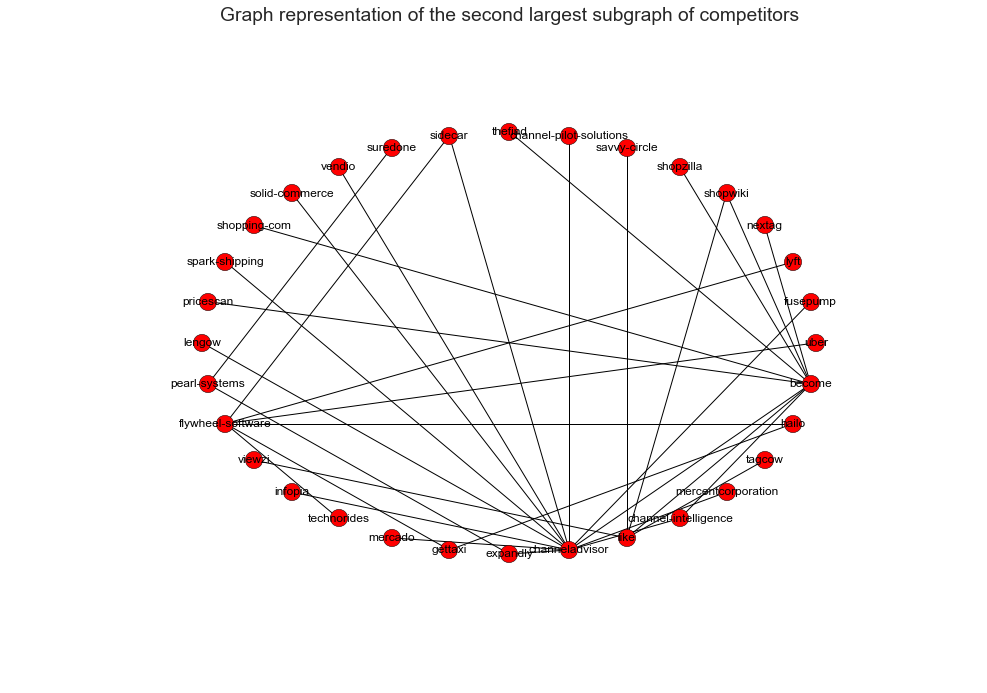

CPU times: user 579 ms, sys: 80.7 ms, total: 660 ms
Wall time: 746 ms


In [508]:
%%time
nx.draw_circular(cc_test, with_labels=True)
plt.title('Graph representation of the second largest subgraph of competitors')
plt.show()

### 4.2 Weighted graph

Here we will use the distance matrix already computed to weight the competitors graph. This means that a link is present only if the companies are already listed as competitors. We then weight this link based on the distance computed from our features.

In [498]:
distance_X_reduced.shape

(6626, 6626)

We need to reduce the keys in our graph to only the ones present in our dataframe (and so distance matrix) because we built the grah on the competitors attribute, which contains a list of companies from Crunchbase. However, we only retrieved a sample of companies because the API calls are really long so many companies listed as competitors are actually not part of this sample.

In [499]:
edges = cc_max.edges()
edges_weighted = [(e1, e2, distance_X_reduced[permalink2index[e1], permalink2index[e2]]) for e1, e2 in edges if e1 in permalink2index.keys() and e2 in permalink2index.keys()]

In [503]:
len(edges_weighted)

295

We reduced the number of the largest connected components to 295 to consider only data for which we know the pairwise distance.

In [501]:
# Creating the graph
cc_max_weighted = nx.Graph()
cc_max_weighted.add_weighted_edges_from(edges_weighted)

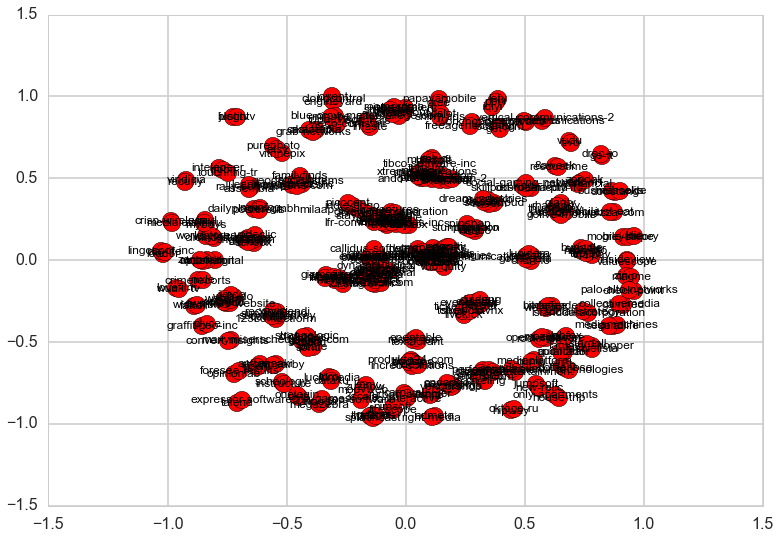

CPU times: user 2.02 s, sys: 199 ms, total: 2.22 s
Wall time: 2.25 s


In [502]:
%%time
nx.draw_networkx(cc_max_weighted, with_labels=True)
plt.show()

It's hard to come up with a nice plot for this graph because of the number of nodes. We will extract the weighted edges list in json to build a prettier visualization on the website.

In [511]:
# Saving the second top connected component
with open("tmp/unweighted_2nd_connected_component.json", "w") as fd:
    json.dump(cc_test.edges(), fd)

# Saving the edges list
with open("tmp/weighted_top_competitors_graph.json", "w") as fd:
    json.dump(edges_weighted, fd)

In [512]:
edges_weighted

[('fantasy-shopper', 'stardoll', 2.6457513110645907),
 ('fantasy-shopper', 'fashiolista', 2.6457513110645907),
 ('skillpod-media-pty-ltd', 'king', 2.8284271247461903),
 ('skillpod-media-pty-ltd', 'oberon-media', 2.2360679774997898),
 ('papayamobile', 'gree', 3.3166247903553998),
 ('livekick', 'showclix', 2.2360679774997898),
 ('jamdatmobile', 'sendme', 2.0),
 ('zuznow', 'moovweb', 2.0),
 ('zuznow', 'kony', 5.196152422706632),
 ('roomorama', 'flatclub', 2.4494897427831779),
 ('secondlife', 'mediamachines', 1.7320508075688772),
 ('secondlife', 'gaia', 1.7320508075688772),
 ('schoox', 'udemy', 2.6457513110645907),
 ('vudu', 'tivo', 2.0),
 ('vitrinepix', 'etsy', 1.7320508075688772),
 ('graffitigeo-inc', 'plyce', 2.6457513110645907),
 ('dejero-labs', 'liveu', 2.6457513110645907),
 ('xtreme-innovations', 'box', 3.0),
 ('yahoo', 'baidu', 2.6457513110645907),
 ('yahoo', 'clickpass', 3.1622776601683795),
 ('yahoo', 'schedjoules-com', 4.0),
 ('yahoo', 'strangelogic', 3.3166247903553998),
 ('yaho